In [1]:
# imports

# external modules
import sys
import os
import numpy as np
import pandas as pd
import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
# framework modules
sys.path.append('../')
import plotting.plottools
importlib.reload(plotting.plottools)
from plotting.plottools import plot_histogram
import training.prepare_training_set
importlib.reload(training.prepare_training_set)
from training.prepare_training_set import prepare_training_data_from_files

2023-11-15 14:27:40.202628: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 14:27:40.273012: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# load the training set

files = ([
    '../data/data/ZeroBias-Run2023C-PromptReco-v1-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet',
    #'../data/data/ZeroBias-Run2023C-PromptReco-v2-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet',
    #'../data/data/ZeroBias-Run2023C-PromptReco-v3-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet',
    #'../data/data/ZeroBias-Run2023C-PromptReco-v4-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet',
    #'../data/data/ZeroBias-Run2023D-PromptReco-v1-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet',
    #'../data/data/ZeroBias-Run2023D-PromptReco-v2-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet',
])
kwargs = ({
    'verbose': True,
    'entries_threshold': 10000,
    'skip_first_lumisections': 5
})
(training_data, training_runs, training_lumis) = prepare_training_data_from_files(files, **kwargs)

Loading file ../data/data/ZeroBias-Run2023C-PromptReco-v1-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet
  Shape of hists array: (18065, 32, 32)
  Runs: [367094 367094 367094 ... 367515 367515 367515]
  Lumis: [  1   2   3 ... 666 667 668]
  Entries: [    0     0     0 ... 69383 67139 23294]
  Passing number of entries: 16503 (91.35 %)
  Passing lumisection skip: 17794 (98.50 %)
  Training lumisections: 16359 (90.56 %)
Shape of training data: (16359, 32, 32, 1)
Shape of training runs: (16359,)
Shape of training lumis: (16359,)


In [3]:
# load keras model
modelname = '../models/model_20231115_Run2023C-v1_PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1.keras'
model = keras.models.load_model(modelname)

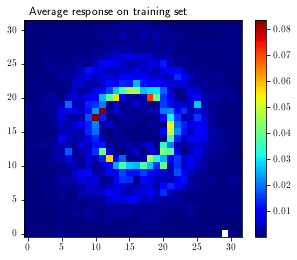

In [8]:
# load average response on training set

avgresponsename = '../models/model_20231115_Run2023C-v1_PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_avgresponse.npy'
avgresponse = np.load(avgresponsename)
fig,ax = plt.subplots()
plot_histogram(avgresponse, fig=fig, ax=ax)
ax.text(0.02, 1.02, 'Average response on training set', transform=ax.transAxes, fontsize=12)
avgresponse[avgresponse==0] = 1
avgresponse = np.expand_dims(avgresponse, axis=2)

In [9]:
# make a mask where values are always zero

shape_mask = (np.sum(training_data, axis=0)==0)[:,:,0]

In [10]:
# evaluate the model

predictions = model.predict(training_data)
predictions[predictions<0] = 0.
predictions[:,shape_mask] = 0.

512/512 [==============================] - 6s 13ms/step


In [12]:
# calculate squared difference

errors = np.square(training_data - predictions)

# space correction
errors_space_corrected = errors/avgresponse

# time correction
errors_time_corrected = np.zeros(errors_space_corrected.shape)
for i in range(2, len(errors)):
    errors_time_corrected[i] = np.prod(errors_space_corrected[i-2:i+1], axis=0)
    
errors_corrected = errors_time_corrected

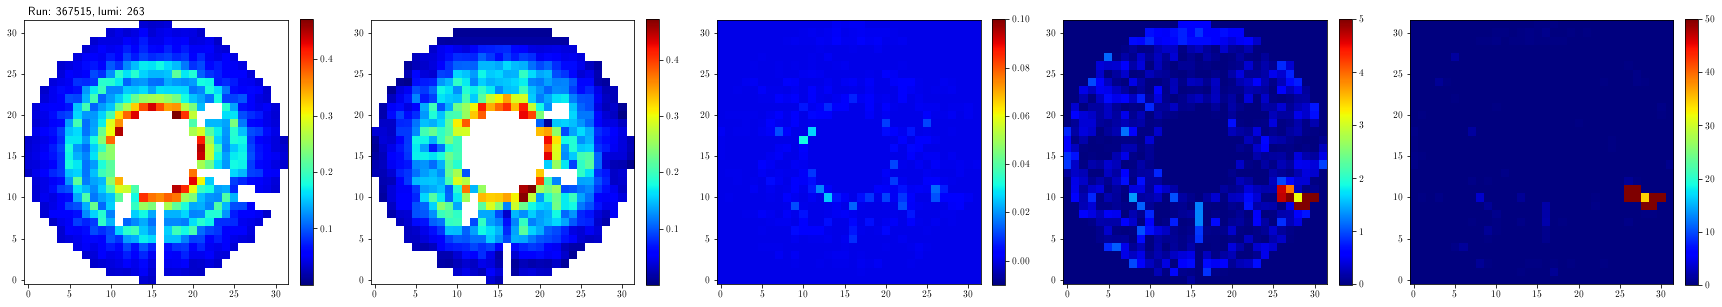

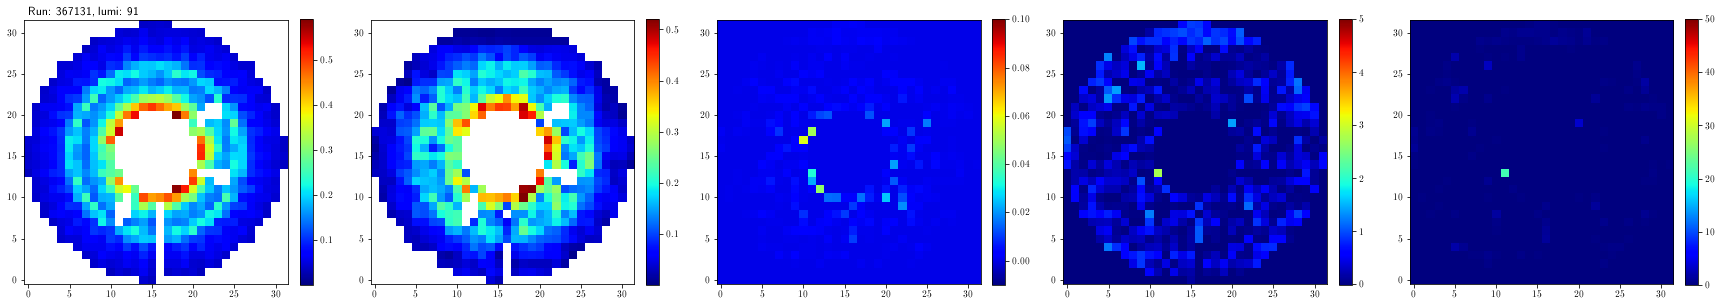

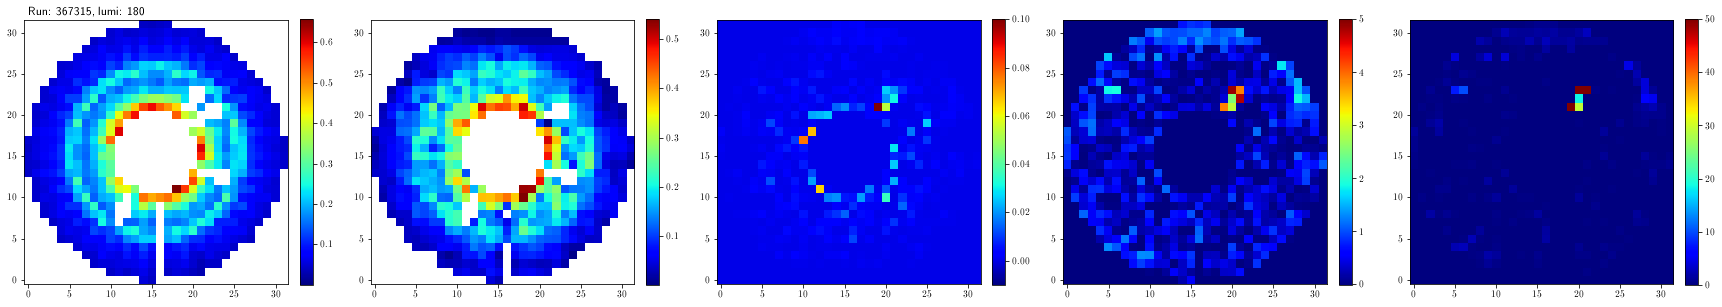

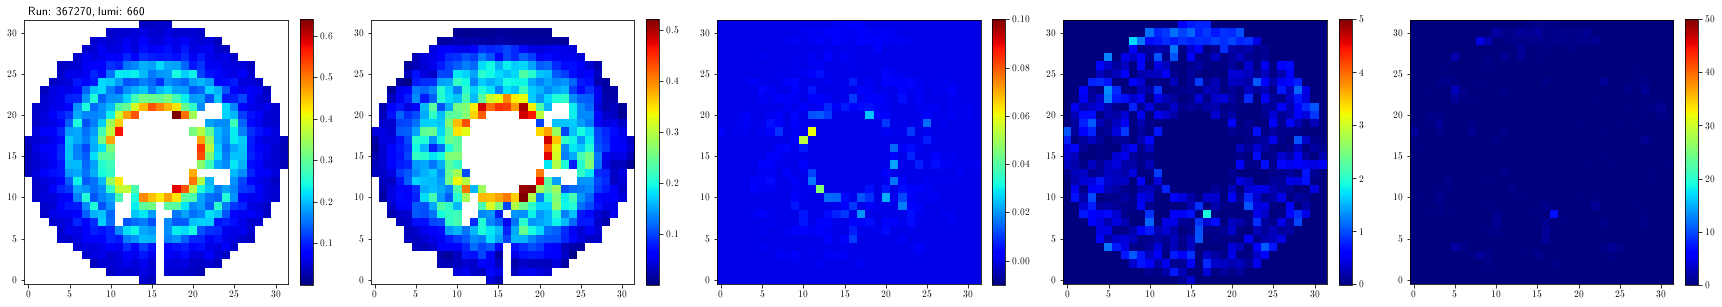

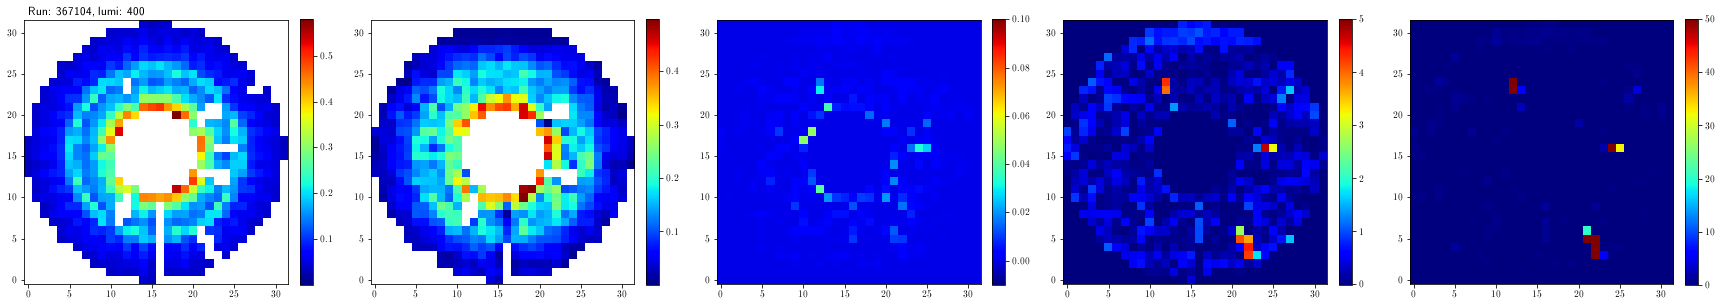

In [13]:
# make plots

nplots = 5
plotids = np.random.choice(len(training_data), size=nplots)

for i in plotids:
    fig,axs = plt.subplots(figsize=(30,6), ncols=5)
    plot_histogram(training_data[i,:,:,0], fig=fig, ax=axs[0])
    plot_histogram(predictions[i,:,:,0], fig=fig, ax=axs[1])
    plot_histogram(errors[i,:,:,0], fig=fig, ax=axs[2], caxrange=(-0.01, 0.1))
    plot_histogram(errors_space_corrected[i,:,:,0], fig=fig, ax=axs[3], caxrange=(-0.01, 5.))
    plot_histogram(errors_time_corrected[i,:,:,0], fig=fig, ax=axs[4], caxrange=(-0.01, 50.))
    axs[0].text(0.02, 1.02, 'Run: {}, lumi: {}'.format(training_runs[i], training_lumis[i]), transform=axs[0].transAxes, fontsize=12)

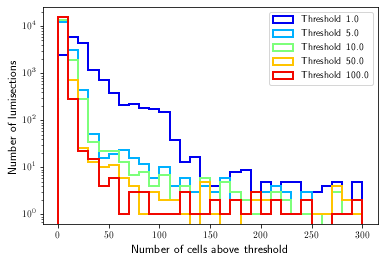

In [14]:
# check how many cells are above a certain threshold

#thresholds = [1., 3., 5., 7., 10.] # for space correction only
thresholds = [1., 5., 10., 50., 100.] # for space + time correction
cmap = mpl.colormaps.get_cmap('jet')
colors = [cmap(val) for val in np.linspace(0.1, 0.9, num=len(thresholds))]
ncells = []
for threshold in thresholds:
    ncells.append( np.sum(np.sum(errors_corrected>threshold, axis=1), axis=1)[:,0] )

fig, ax = plt.subplots()
for i, (threshold, ncell) in enumerate(zip(thresholds, ncells)):
    ax.hist(ncell, histtype='step', linewidth=2,
            color=colors[i], label='Threshold {}'.format(threshold),
            range=(0, 300), bins=30)
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Number of cells above threshold', fontsize=12)
    ax.set_ylabel('Number of lumisections', fontsize=12)

Running on cell range (0, 3)
Found 11112 candidate lumisections


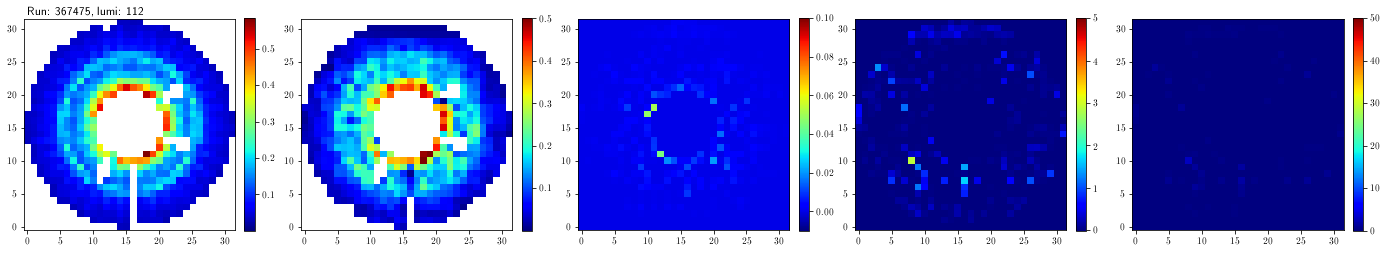

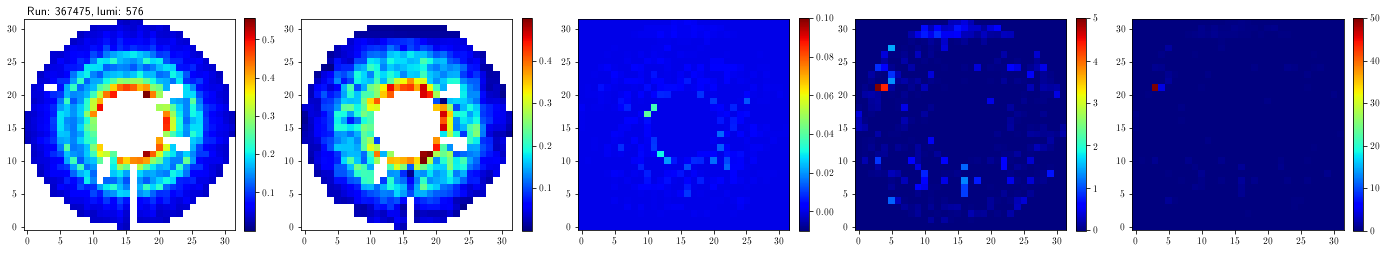

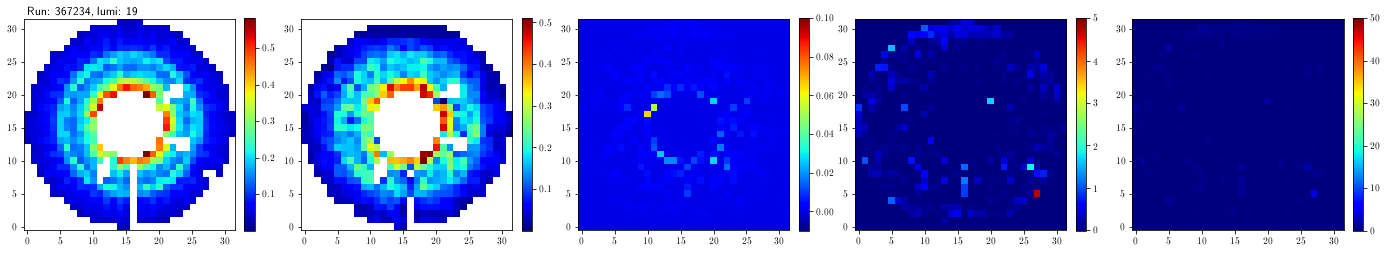

Running on cell range (4, 10)
Found 4570 candidate lumisections


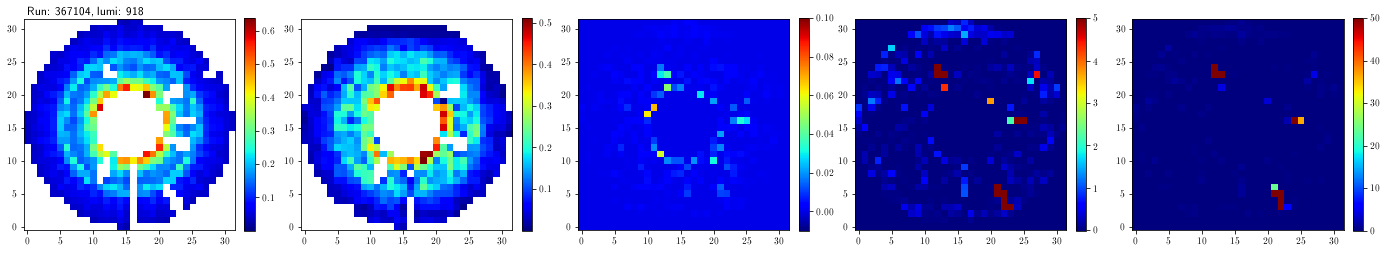

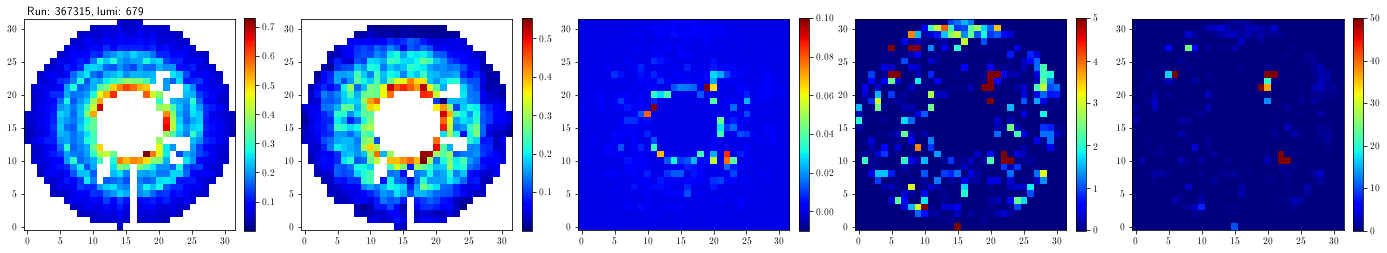

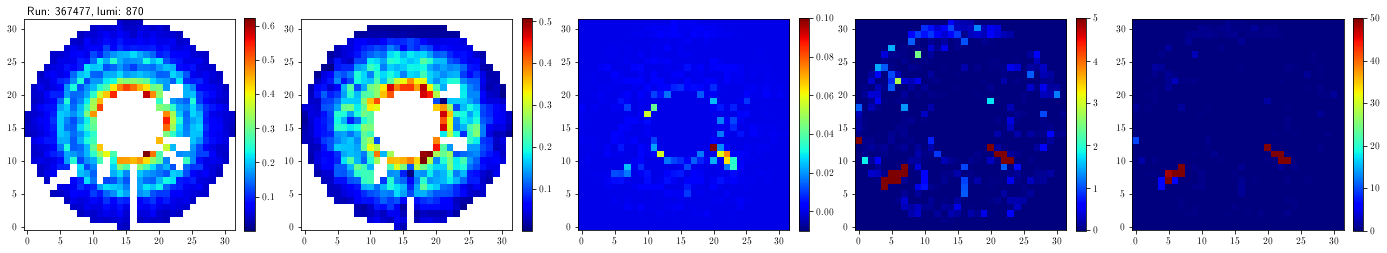

Running on cell range (10, 100)
Found 779 candidate lumisections


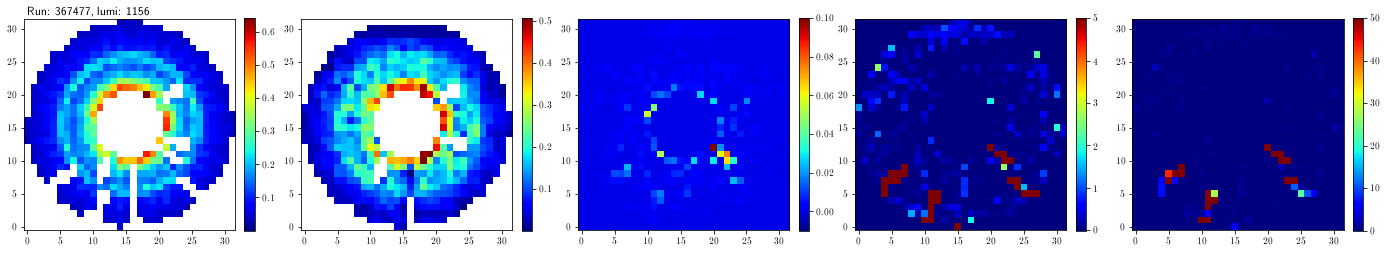

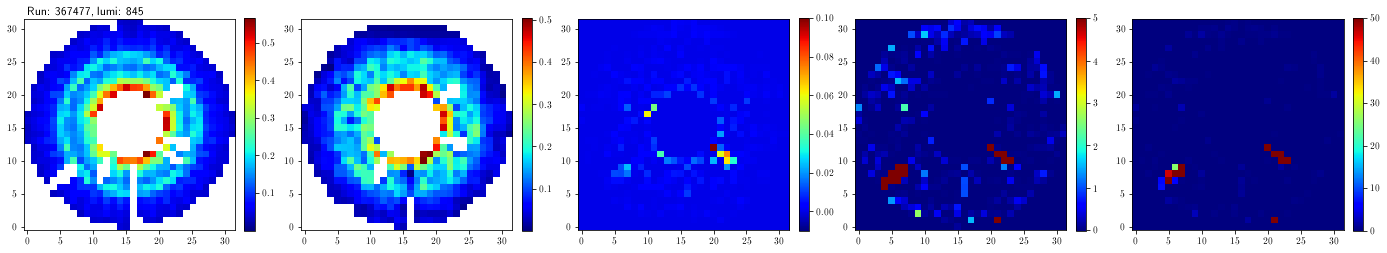

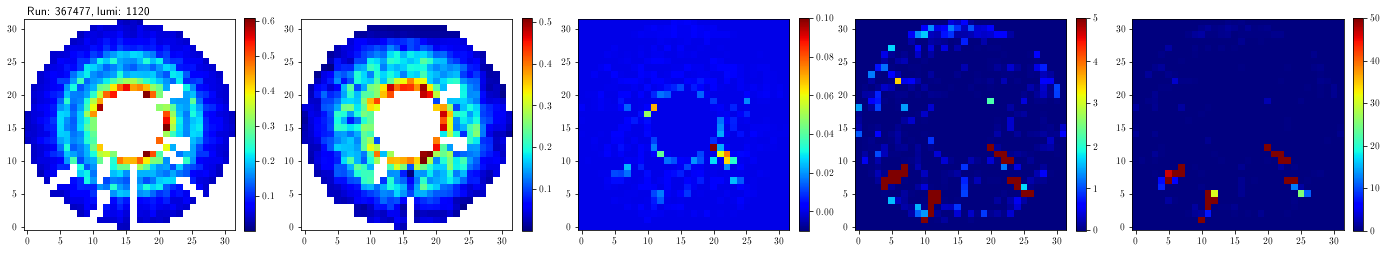

In [15]:
# plot examples from across the range

threshold = 50.
ncells = np.sum(np.sum(errors_corrected>threshold, axis=1), axis=1)[:,0]
ncellranges = ([
    (0, 3),
    (4, 10),
    (10, 100)
])

all_indices = np.array(range(len(training_data)))
for ncellrange in ncellranges:
    mask = ((ncells>=ncellrange[0]) & (ncells<=ncellrange[1]))
    candidate_indices = all_indices[mask]
    nplots = 3
    plotids = np.random.choice(candidate_indices, size=nplots)
    print('Running on cell range {}'.format(ncellrange))
    print('Found {} candidate lumisections'.format(len(candidate_indices)))

    for i in plotids:
        fig,axs = plt.subplots(figsize=(24,6), ncols=5)
        plot_histogram(training_data[i,:,:,0], fig=fig, ax=axs[0])
        plot_histogram(predictions[i,:,:,0], fig=fig, ax=axs[1])
        plot_histogram(errors[i,:,:,0], fig=fig, ax=axs[2], caxrange=(-0.01, 0.1))
        plot_histogram(errors_corrected[i,:,:,0], fig=fig, ax=axs[3], caxrange=(-0.01, 5.))
        plot_histogram(errors_time_corrected[i,:,:,0], fig=fig, ax=axs[4], caxrange=(-0.01, 50.))
        axs[0].text(0.02, 1.02, 'Run: {}, lumi: {}'.format(training_runs[i], training_lumis[i]), transform=axs[0].transAxes, fontsize=12)
    plt.show()